# 周波数ドメイン2

In [1]:
!wget https://github.com/eiichiromomma/CVMLAB/raw/master/img/sample.jpg
!wget https://github.com/eiichiromomma/CVMLAB/raw/master/img/cal.jpeg
!wget https://github.com/eiichiromomma/CVMLAB/raw/master/img/cos2img.jpg
!wget http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2004/07/saturn_s_rings_-_1_july_2004/10096645-2-eng-GB/Saturn_s_rings_-_1_July_2004.jpe
!wget https://upload.wikimedia.org/wikipedia/commons/1/14/IRIB_Testcard_%28FuBK_Version%29.jpg
!pip install japanize-matplotlib

--2021-06-21 05:19:21--  https://github.com/eiichiromomma/CVMLAB/raw/master/img/sample.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/sample.jpg [following]
--2021-06-21 05:19:21--  https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78522 (77K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  76.68K  --.-KB/s    in 0.008s  

2021-06-21 05:19:21 (9.00 MB/s) - ‘sample.jpg’ saved [78522/78522]

--2021-06-21 05:19:22--  https://github.com/eiichiromom

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import japanize_matplotlib
# plt.rc('xtick', bottom=False, labelbottom=False)
# plt.rc('ytick', left = False, labelleft = False)
plt.rc('figure', figsize=[24,12])

## freqz2の代わり
MATLABにはfreqz2で空間フィルタの周波数応答を見る関数が用意されているが，Pythonには存在しない。スケールが合っていて，結果の周波数分解能が原画像と同じであれば良いので，
1. 原画像と同サイズのzerosを用意
2. 1.の行列の左上にフィルタを置く(前述のパディングする方法と同じ意味)
3. 2.の行列をfft2で応答が得られる(可視化の際にはfftshift)


[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]


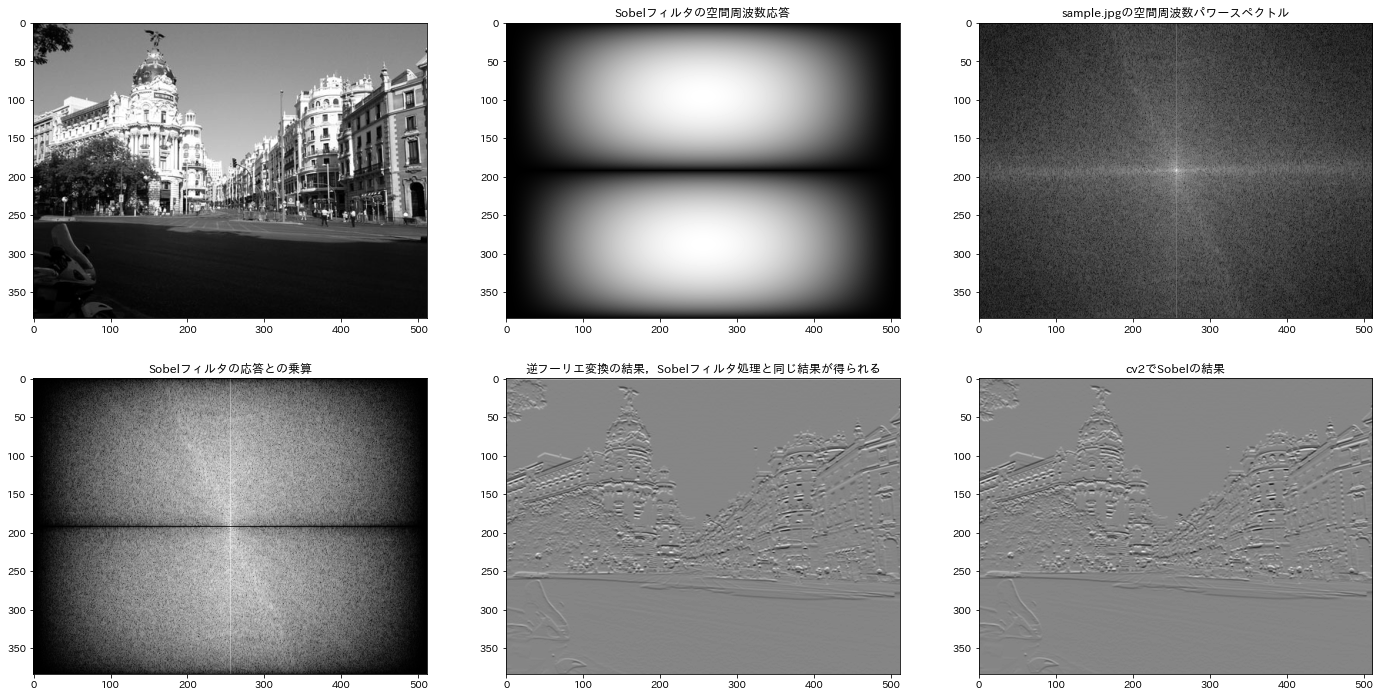

In [3]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
k = np.array([[1, 2, 1],[0, 0, 0],[-1,-2,-1]], dtype=np.float)
print(k)
# 原画像と同じサイズの0行列を用意し，カーネルを1つだけ上書きする(3x3)
zimg = np.zeros(gimg.shape, dtype=np.float)
zimg[0:k.shape[0], 0:k.shape[1]] = k
fz = np.fft.fft2(zimg)
fz = np.fft.fftshift(fz)
plt.subplot(2,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(fz)+1), cmap='gray')
plt.title('Sobelフィルタの空間周波数応答')
fimg = np.fft.fft2(gimg/255.)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,3,3)
plt.imshow(np.log(np.abs(fimg)+1), cmap='gray')
plt.title('sample.jpgの空間周波数パワースペクトル')
fdst = np.multiply(fimg, fz)
plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(fdst)+1), cmap='gray')
plt.title('Sobelフィルタの応答との乗算')
fdst = np.fft.fftshift(fdst)
ifdst = np.fft.ifft2(fdst)
plt.subplot(2,3,5)
plt.imshow(np.real(ifdst), cmap='gray')
plt.title('逆フーリエ変換の結果，Sobelフィルタ処理と同じ結果が得られる');
plt.subplot(2,3,6)
plt.imshow(cv2.Sobel(gimg/255., -1, dx=0, dy=1, ksize=3), cmap='gray')
#plt.imshow(cv2.filter2D(gimg/255., -1, k), cmap='gray') #勾配が反転するが特に問題ない
plt.title('cv2でSobelの結果');

# ILPF(理想ローパスフィルタ)
指定した半径に応じた空間周波数でカットするLPF。応答が急峻にカットすることから「理想」と名前がついているが，処理結果にはリンギングが発生するため「理想的なフィルタ」ではない点に注意

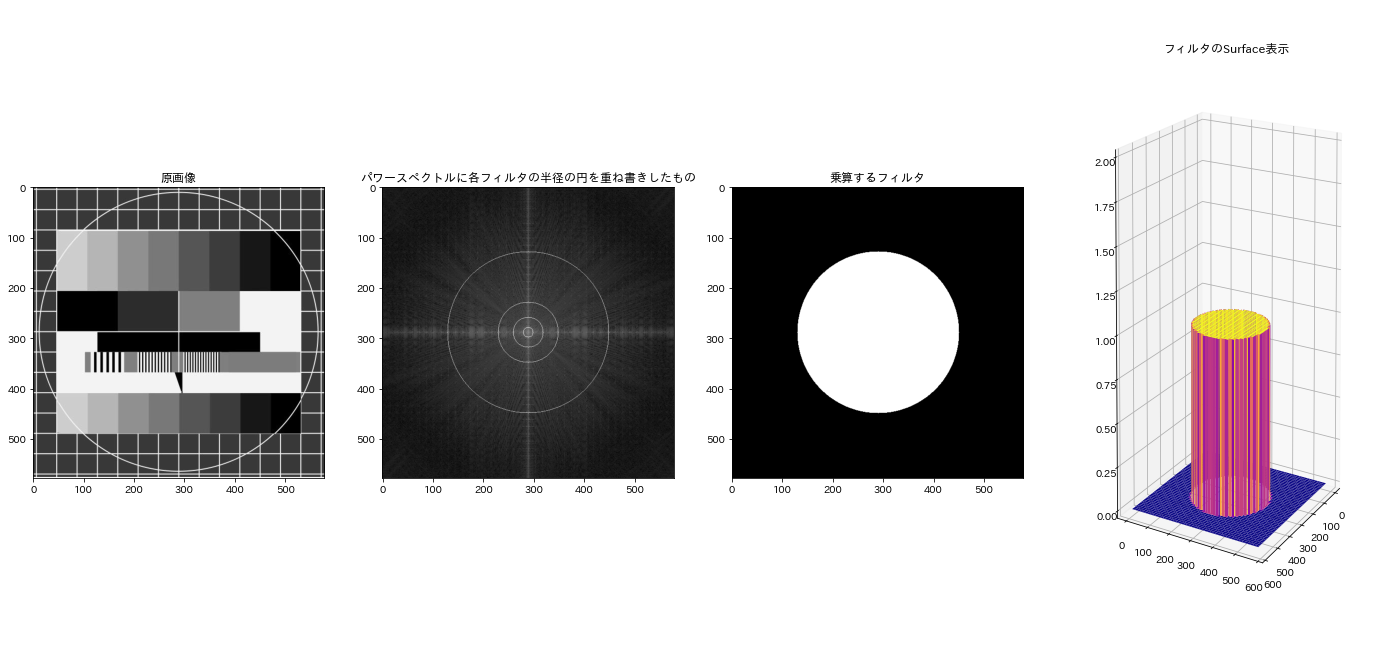

In [4]:
from mpl_toolkits.mplot3d import axes3d
gimg = cv2.imread('IRIB_Testcard_(FuBK_Version).jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = gimg[:, 95:95+578]
fgimg = np.fft.fft2(gimg)
fgimg = np.fft.fftshift(fgimg)
tmpimg = np.zeros(gimg.shape)
h, w = gimg.shape
cutoff = [10, 30, 60, 160]
for r in cutoff:
  tmpimg = cv2.circle(tmpimg, (w//2, h//2), r, 1.0)
mask = np.zeros(gimg.shape)
mask = cv2.circle(mask, (w//2, h//2), cutoff[3], 1.0, -1)
plt.subplot(1,4,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(1,4,2)
plt.imshow(10*tmpimg+np.log(np.abs(fgimg)+1), cmap='gray')
plt.title('パワースペクトルに各フィルタの半径の円を重ね書きしたもの')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('乗算するフィルタ')
ax3d = plt.subplot(1,4,4, projection = '3d')
x = np.linspace(0, mask.shape[1], num=mask.shape[1])
y = np.linspace(0, mask.shape[0], num=mask.shape[0])
X, Y = np.meshgrid(x,y)
#ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=10, azim=30)
ax3d.plot_surface(X, Y, mask, cmap='plasma')
ax3d.set_zlim(0, 2.0);
plt.title('フィルタのSurface表示');

## ILPFによるフィルタ処理例
上記の各半径でのフィルタの結果。

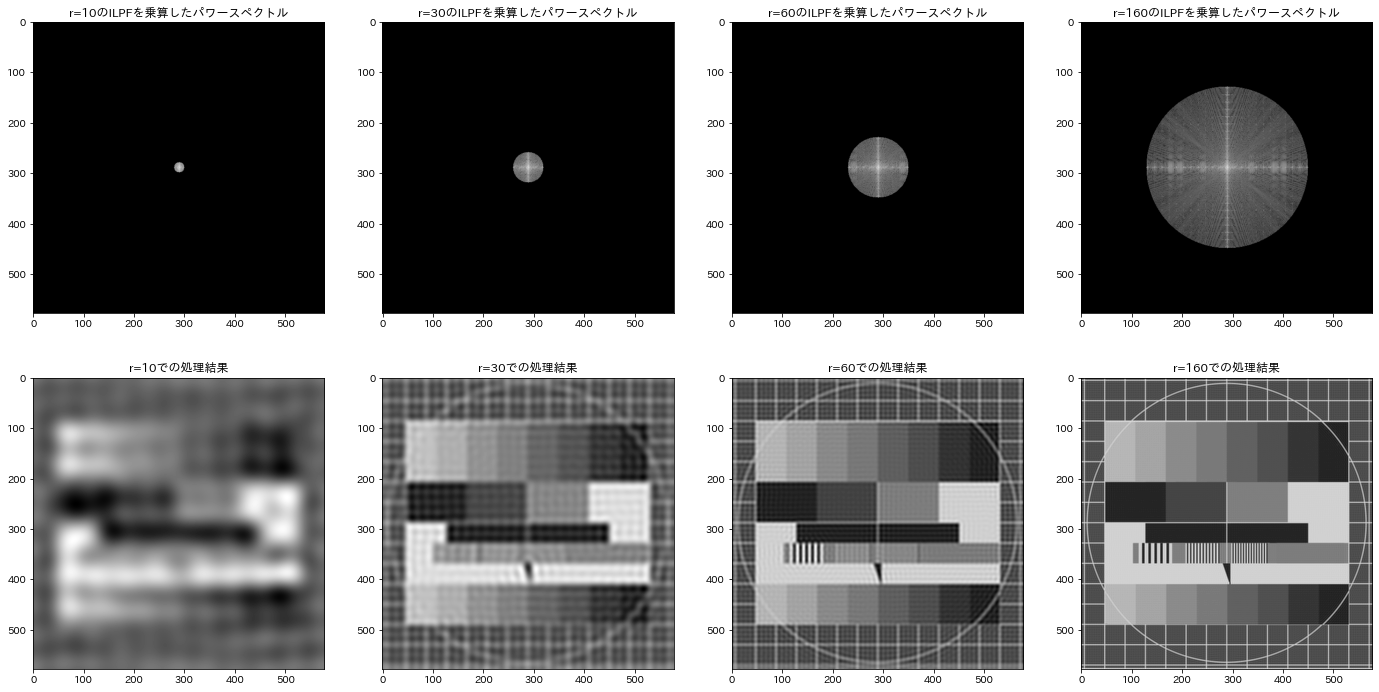

In [5]:
for i, r in enumerate(cutoff):
  mask = np.zeros(gimg.shape)
  mask = cv2.circle(mask, (w//2, h//2), r, 1.0, -1)
  fmaskedimg = fgimg * mask
  plt.subplot(2,4,i+1)
  plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
  plt.title(f'r={r}のILPFを乗算したパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,4, i+5)
  plt.imshow(np.real(maskedimg), cmap='gray')
  plt.title(f'r={r}での処理結果')

# 縦横の正弦波へのILPFの例
縦方向の正弦波と横方向の正弦波の模様で，横方向の方が4倍周波数が高い状態のため，カットオフの半径を徐々に広げていくと，最初は直流成分だけだったものが縦方向の模様，横方向の模様と重ね書きされていく様子がわかる。

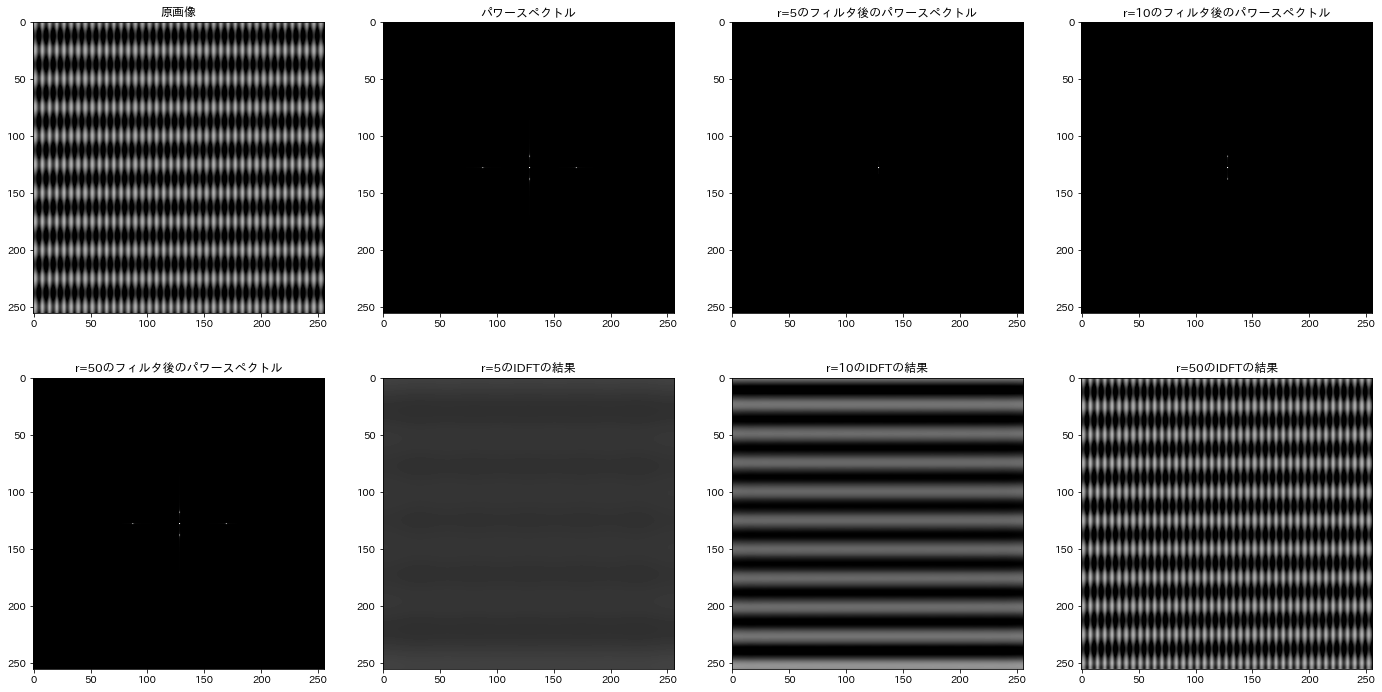

In [6]:
cutoff = [5, 10, 50]
x = np.linspace(0, 256, 256)
y = np.linspace(0, 256, 256)
xx, yy = np.meshgrid(x, y)
img = 0.25 * np.sin(xx/1) + 0.25 * np.cos(yy/4.) + 0.2
h, w = img.shape
plt.subplot(2,4,1)
plt.imshow(img, cmap='gray', vmin = 0, vmax = 1.0)
plt.title('原画像')
fimg = np.fft.fft2(img)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,4,2)
plt.imshow(np.abs(fimg), cmap='gray')
plt.title('パワースペクトル')
max = np.abs(fimg).max()
for i, r in enumerate(cutoff):
  mask = np.zeros(img.shape)
  mask = cv2.circle(mask, (w//2, h//2), r, 1.0, -1)
  fmaskedimg = fimg * mask
  plt.subplot(2,4,i+3)
  plt.imshow(np.abs(fmaskedimg), cmap='gray', vmin=0, vmax=max)
  plt.title(f'r={r}のフィルタ後のパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,4, i+6)
  plt.imshow(np.real(maskedimg), cmap='gray', vmin=0, vmax=1.0)
  plt.title(f'r={r}のIDFTの結果')

# ガウシアンLPF
ガウシアンLPFは両ドメインにおいてガウシアン関数になるためわかりやすい。
この例でもカットオフのサイズを変えてパワースペクトルに乗算している。ガウシアンなので設定した半径より小さく見える（減衰している）

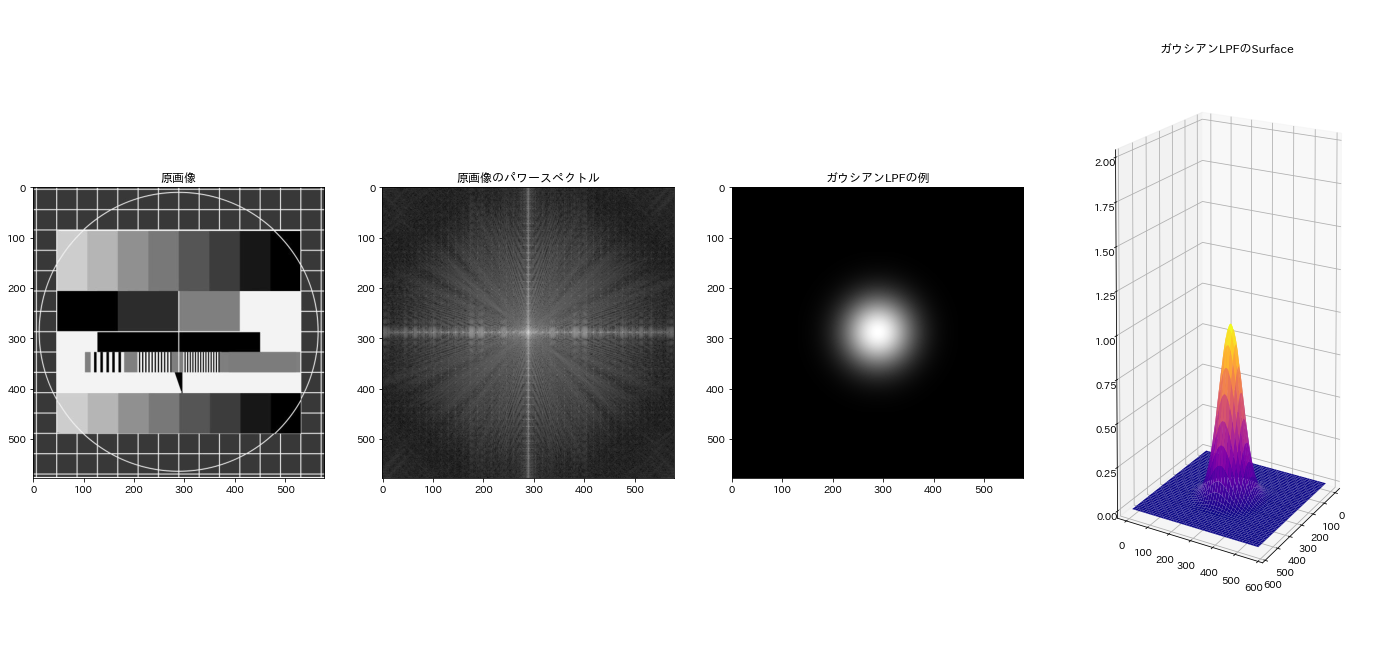

In [7]:
from mpl_toolkits.mplot3d import axes3d
gimg = cv2.imread('IRIB_Testcard_(FuBK_Version).jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = gimg[:, 95:95+578]
fgimg = np.fft.fft2(gimg)
fgimg = np.fft.fftshift(fgimg)
tmpimg = np.zeros(gimg.shape)
h, w = gimg.shape
cutoff = [10, 60, 120, 320]
kern = cv2.getGaussianKernel(cutoff[3],-1)
kern2 = np.dot(kern, kern.T)
kern2 = kern2/kern2.max()

mask = np.zeros(gimg.shape)
mask[h//2 - cutoff[3]//2:h//2+cutoff[3]//2,w//2 - cutoff[3]//2:w//2+cutoff[3]//2] = kern2
plt.subplot(1,4,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(1,4,2)
plt.imshow(10*tmpimg+np.log(np.abs(fgimg)+1), cmap='gray')
plt.title('原画像のパワースペクトル')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('ガウシアンLPFの例')
ax3d = plt.subplot(1,4,4, projection = '3d')
x = np.linspace(0, mask.shape[1], num=mask.shape[1])
y = np.linspace(0, mask.shape[0], num=mask.shape[0])
X, Y = np.meshgrid(x,y)
#ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=10, azim=30)
ax3d.plot_surface(X, Y, mask, cmap='plasma')
ax3d.set_zlim(0, 2.0);
plt.title('ガウシアンLPFのSurface');

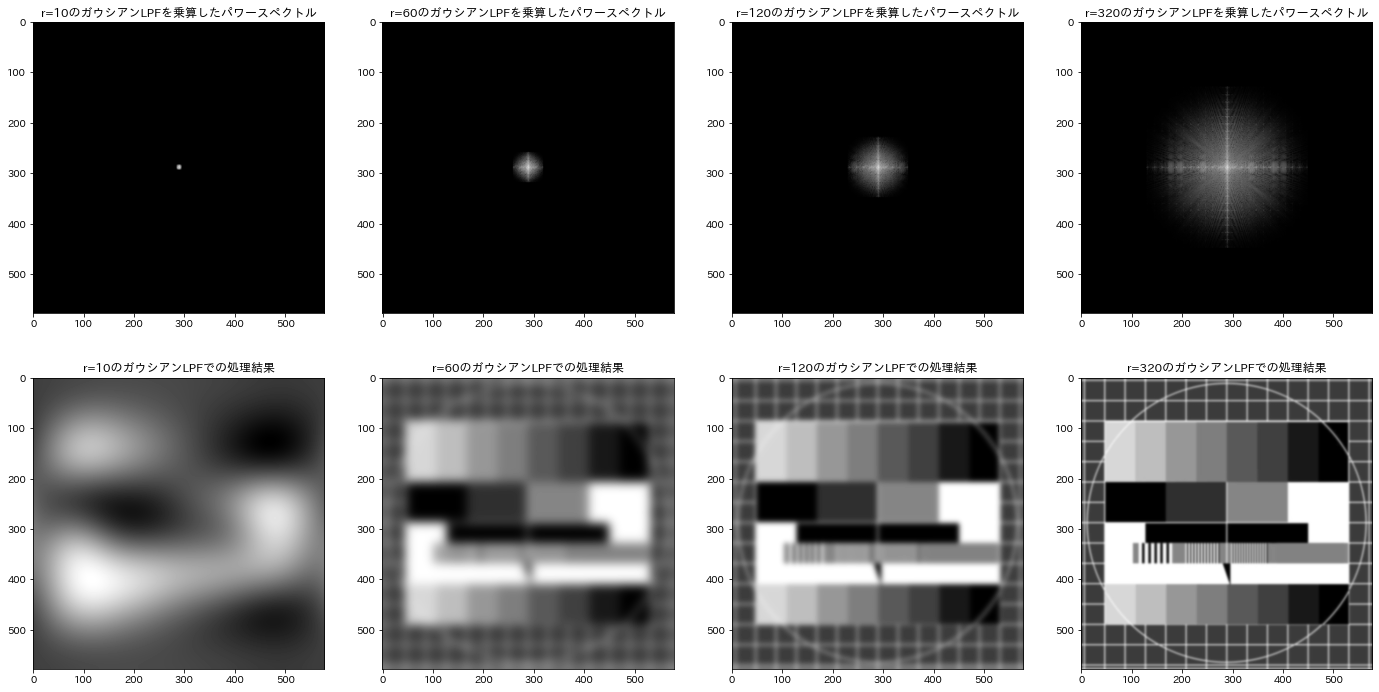

In [8]:
for i, r in enumerate(cutoff):
  kern = cv2.getGaussianKernel(r,-1)
  kern2 = np.dot(kern, kern.T)
  kern2 = kern2/kern2.max()
  mask = np.zeros(gimg.shape)
  mask[h//2 - r//2:h//2+r//2,w//2 - r//2:w//2+r//2] = kern2
  fmaskedimg = fgimg * mask
  plt.subplot(2,4,i+1)
  plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
  plt.title(f'r={r}のガウシアンLPFを乗算したパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,4, i+5)
  plt.imshow(np.real(maskedimg), cmap='gray')
  plt.title(f'r={r}のガウシアンLPFでの処理結果')

# IHPF(理想ハイパスフィルタ)
指定した半径に応じた空間周波数より高い空間周波数をパスするHPF。ILPF同様に応答が急峻にカットすることから「理想」と名前がついているが，処理結果にはリンギングが発生するため「理想的なフィルタ」ではない点に注意。
フィルタは1-HLPFで作れる

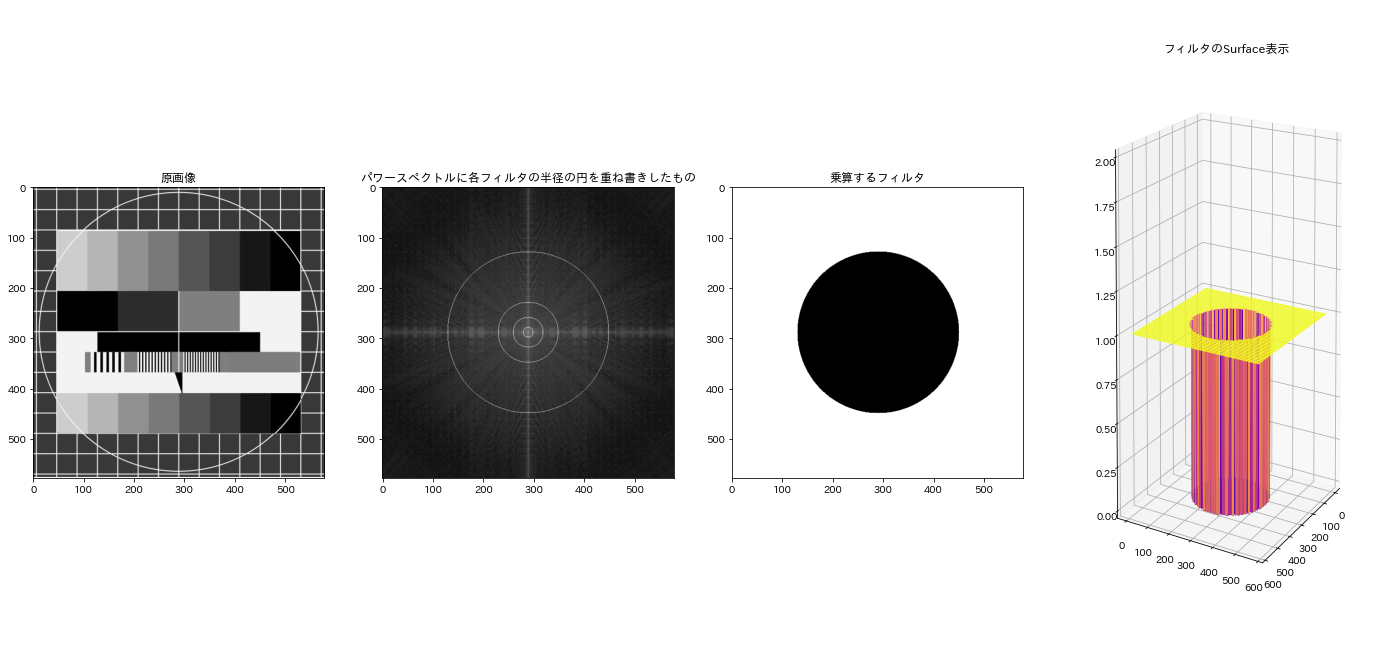

In [9]:
from mpl_toolkits.mplot3d import axes3d
gimg = cv2.imread('IRIB_Testcard_(FuBK_Version).jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = gimg[:, 95:95+578]
fgimg = np.fft.fft2(gimg)
fgimg = np.fft.fftshift(fgimg)
tmpimg = np.zeros(gimg.shape)
h, w = gimg.shape
cutoff = [10, 30, 60, 160]
for r in cutoff:
  tmpimg = cv2.circle(tmpimg, (w//2, h//2), r, 1.0)
mask = np.zeros(gimg.shape)
mask = cv2.circle(mask, (w//2, h//2), cutoff[3], 1.0, -1)
mask = 1-mask
plt.subplot(1,4,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(1,4,2)
plt.imshow(10*tmpimg+np.log(np.abs(fgimg)+1), cmap='gray')
plt.title('パワースペクトルに各フィルタの半径の円を重ね書きしたもの')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('乗算するフィルタ')
ax3d = plt.subplot(1,4,4, projection = '3d')
x = np.linspace(0, mask.shape[1], num=mask.shape[1])
y = np.linspace(0, mask.shape[0], num=mask.shape[0])
X, Y = np.meshgrid(x,y)
#ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=10, azim=30)
ax3d.plot_surface(X, Y, mask, cmap='plasma')
ax3d.set_zlim(0, 2.0);
plt.title('フィルタのSurface表示');

## IHPFによるフィルタ処理例
上記の各半径でのフィルタの結果。

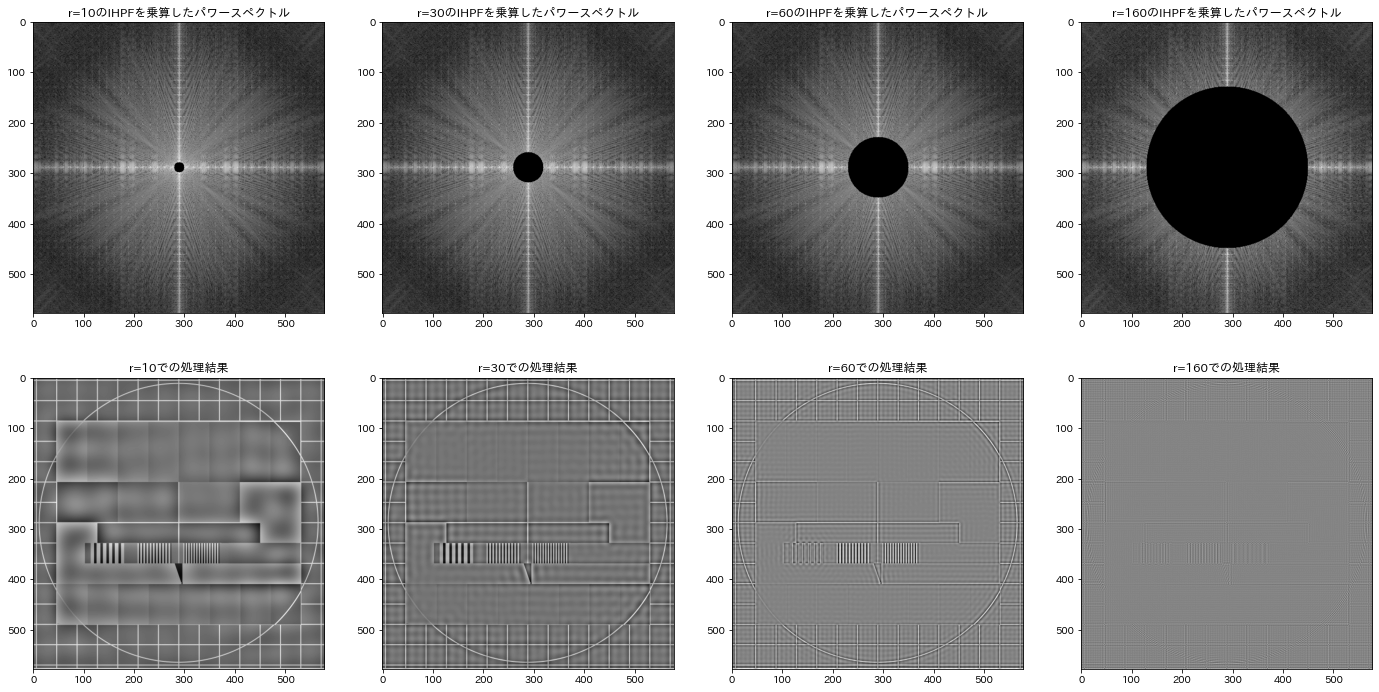

In [10]:
for i, r in enumerate(cutoff):
  mask = np.zeros(gimg.shape)
  mask = cv2.circle(mask, (w//2, h//2), r, 1.0, -1)
  mask = 1-mask
  fmaskedimg = fgimg * mask
  plt.subplot(2,4,i+1)
  plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
  plt.title(f'r={r}のIHPFを乗算したパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,4, i+5)
  plt.imshow(np.real(maskedimg), cmap='gray')
  plt.title(f'r={r}での処理結果')

# ガウシアンHPF
ガウシアンHPFもIHPF同様に1からLPFを引くだけで良い。
この例でもカットオフのサイズを変えてパワースペクトルに乗算している。ガウシアンなので設定した半径より小さく見える（減衰している）

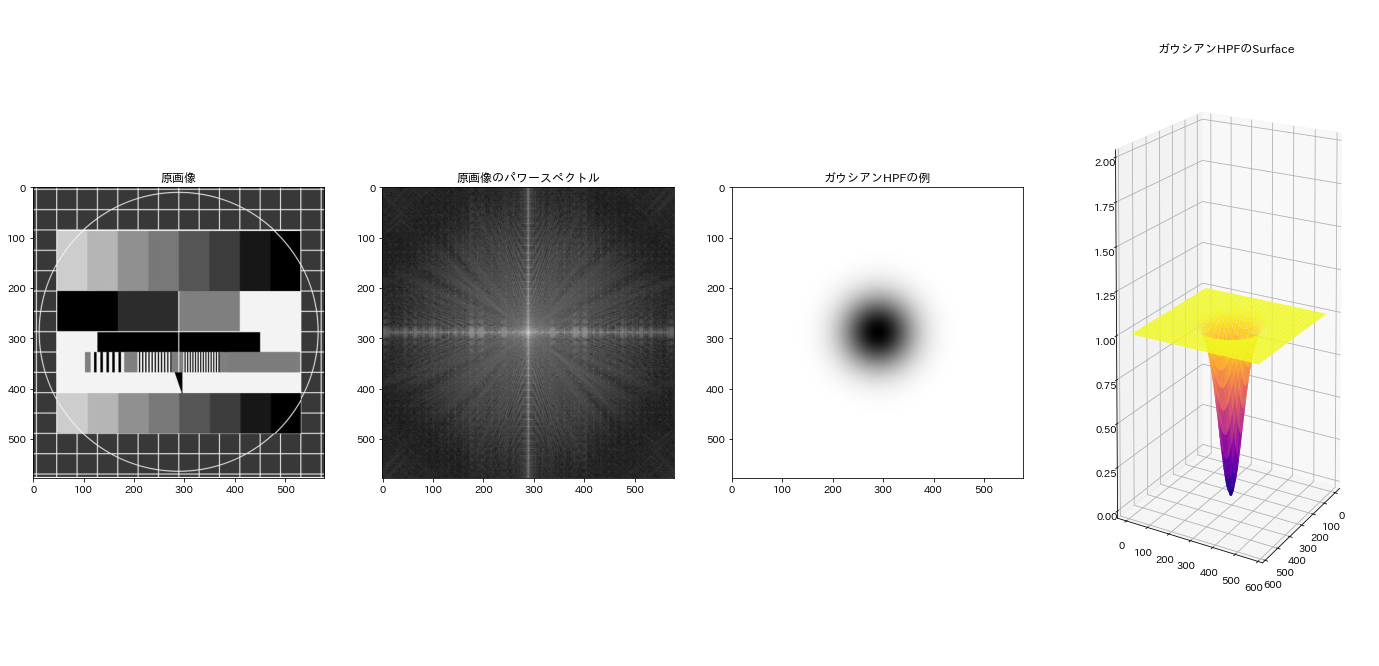

In [11]:
from mpl_toolkits.mplot3d import axes3d
gimg = cv2.imread('IRIB_Testcard_(FuBK_Version).jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = gimg[:, 95:95+578]
fgimg = np.fft.fft2(gimg)
fgimg = np.fft.fftshift(fgimg)
tmpimg = np.zeros(gimg.shape)
h, w = gimg.shape
cutoff = [10, 60, 120, 320]
kern = cv2.getGaussianKernel(cutoff[3],-1)
kern2 = np.dot(kern, kern.T)
kern2 = kern2/kern2.max()

mask = np.zeros(gimg.shape)
mask[h//2 - cutoff[3]//2:h//2+cutoff[3]//2,w//2 - cutoff[3]//2:w//2+cutoff[3]//2] = kern2
mask = 1-mask
plt.subplot(1,4,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(1,4,2)
plt.imshow(10*tmpimg+np.log(np.abs(fgimg)+1), cmap='gray')
plt.title('原画像のパワースペクトル')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('ガウシアンHPFの例')
ax3d = plt.subplot(1,4,4, projection = '3d')
x = np.linspace(0, mask.shape[1], num=mask.shape[1])
y = np.linspace(0, mask.shape[0], num=mask.shape[0])
X, Y = np.meshgrid(x,y)
#ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=10, azim=30)
ax3d.plot_surface(X, Y, mask, cmap='plasma')
ax3d.set_zlim(0, 2.0);
plt.title('ガウシアンHPFのSurface');

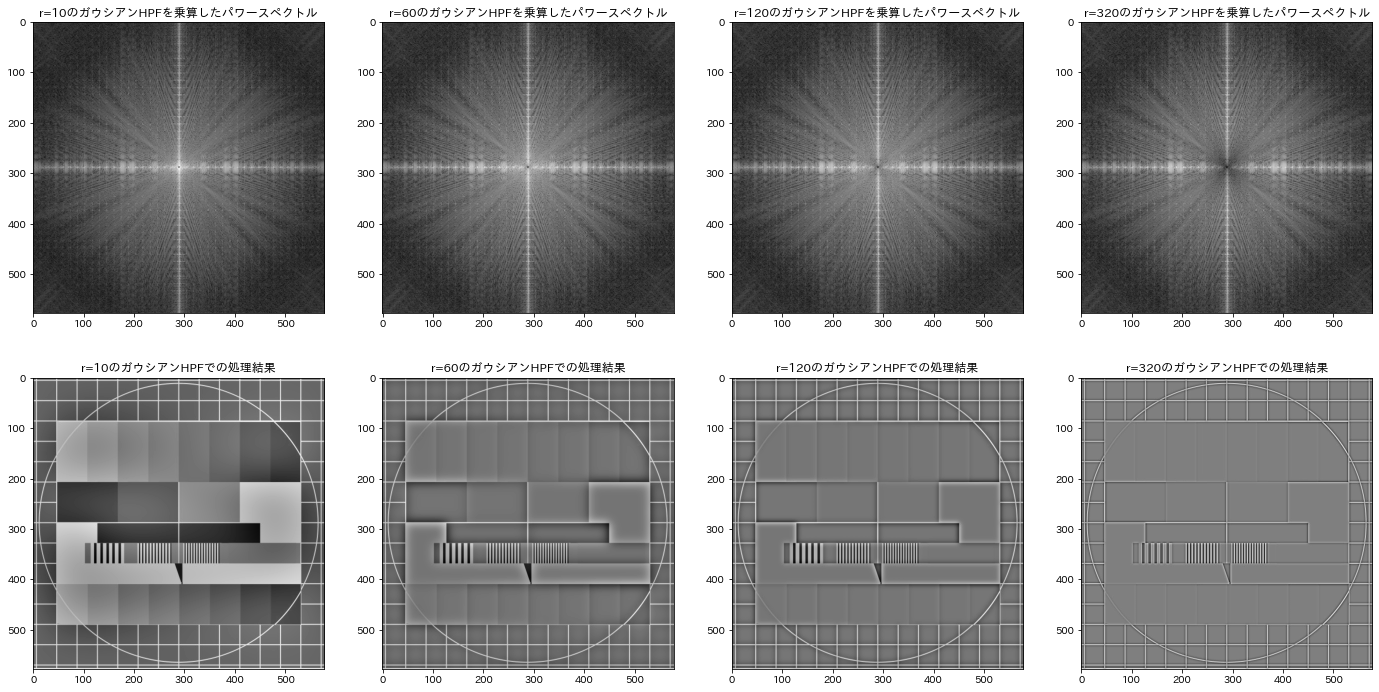

In [12]:
for i, r in enumerate(cutoff):
  kern = cv2.getGaussianKernel(r,-1)
  kern2 = np.dot(kern, kern.T)
  kern2 = kern2/kern2.max()
  mask = np.zeros(gimg.shape)
  mask[h//2 - r//2:h//2+r//2,w//2 - r//2:w//2+r//2] = kern2
  mask = 1 - mask
  fmaskedimg = fgimg * mask
  plt.subplot(2,4,i+1)
  plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
  plt.title(f'r={r}のガウシアンHPFを乗算したパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,4, i+5)
  plt.imshow(np.real(maskedimg), cmap='gray')
  plt.title(f'r={r}のガウシアンHPFでの処理結果')

# IBPF(理想バンドパスフィルタ)
ILPFで作ったフィルタの内側に0の円を書く

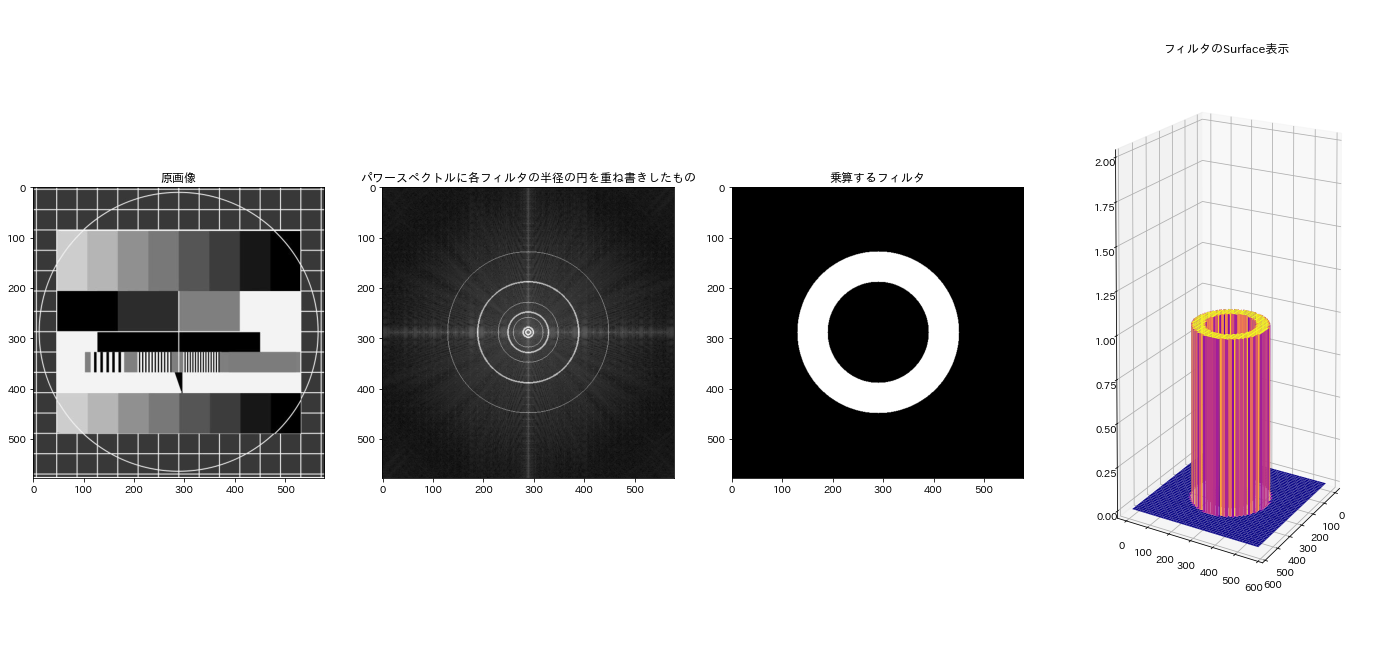

In [13]:
from mpl_toolkits.mplot3d import axes3d
gimg = cv2.imread('IRIB_Testcard_(FuBK_Version).jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = gimg[:, 95:95+578]
fgimg = np.fft.fft2(gimg)
fgimg = np.fft.fftshift(fgimg)
tmpimg = np.zeros(gimg.shape)
h, w = gimg.shape
cutoff = [10, 30, 60, 160]
cutoff2 = [5, 10, 40, 100]
for i in range(len(cutoff)):
  tmpimg = cv2.circle(tmpimg, (w//2, h//2), cutoff[i], 1.0)
  tmpimg = cv2.circle(tmpimg, (w//2, h//2), cutoff2[i], 1.0, 2) #太い線が内側
mask = np.zeros(gimg.shape)
mask = cv2.circle(mask, (w//2, h//2), cutoff[3], 1.0, -1)
mask = cv2.circle(mask, (w//2, h//2), cutoff2[3], 0.0, -1)
plt.subplot(1,4,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(1,4,2)
plt.imshow(10*tmpimg+np.log(np.abs(fgimg)+1), cmap='gray')
plt.title('パワースペクトルに各フィルタの半径の円を重ね書きしたもの')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('乗算するフィルタ')
ax3d = plt.subplot(1,4,4, projection = '3d')
x = np.linspace(0, mask.shape[1], num=mask.shape[1])
y = np.linspace(0, mask.shape[0], num=mask.shape[0])
X, Y = np.meshgrid(x,y)
#ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=10, azim=30)
ax3d.plot_surface(X, Y, mask, cmap='plasma')
ax3d.set_zlim(0, 2.0);
plt.title('フィルタのSurface表示');

## IBPFによるフィルタ処理例
上記の各半径でのフィルタの結果。
40-60と100-160の結果でやや下のしましまが抽出される場所が異なるのがわかる。

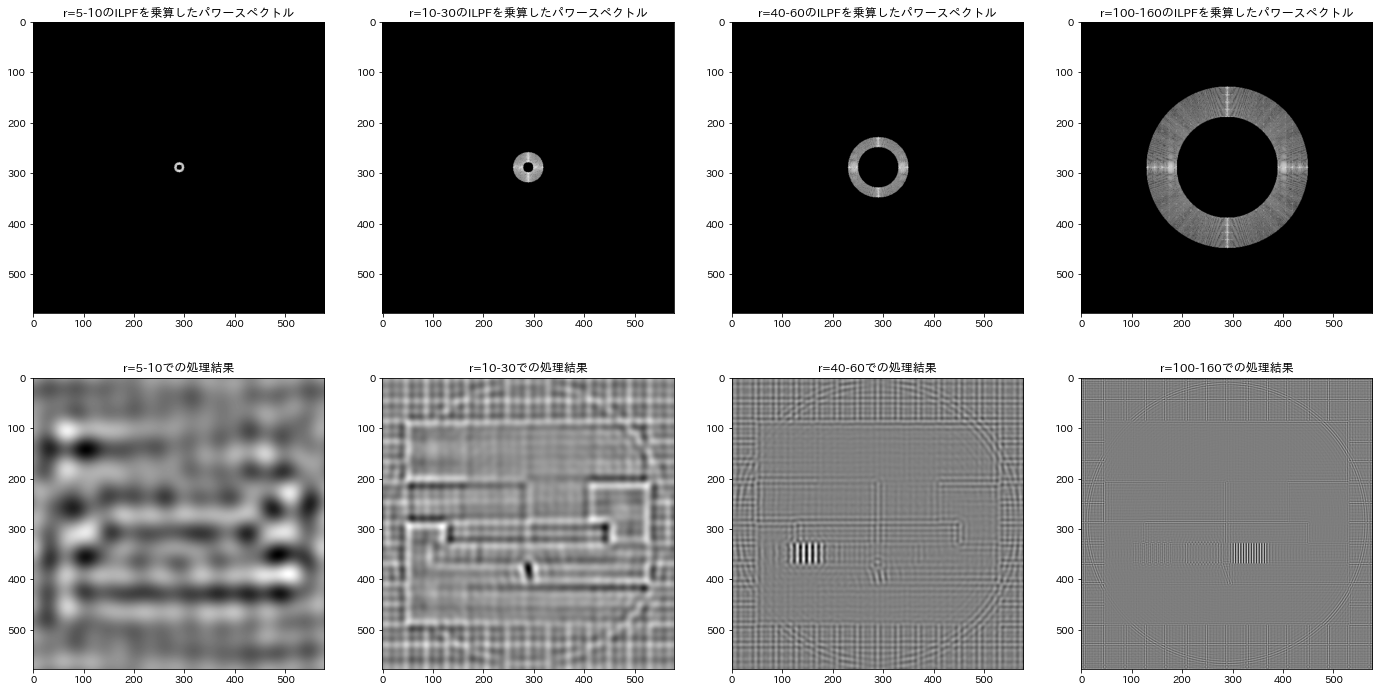

In [14]:
for i, r in enumerate(cutoff):
  mask = np.zeros(gimg.shape)
  mask = cv2.circle(mask, (w//2, h//2), r, 1.0, -1)
  mask = cv2.circle(mask, (w//2, h//2), cutoff2[i], 0.0, -1)
  fmaskedimg = fgimg * mask
  plt.subplot(2,4,i+1)
  plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
  plt.title(f'r={cutoff2[i]}-{r}のILPFを乗算したパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,4, i+5)
  plt.imshow(np.real(maskedimg), cmap='gray')
  plt.title(f'r={cutoff2[i]}-{r}での処理結果')

# 高域強調フィルタ
ガウシアンHPFをk倍したものに原画像を加えたもの。


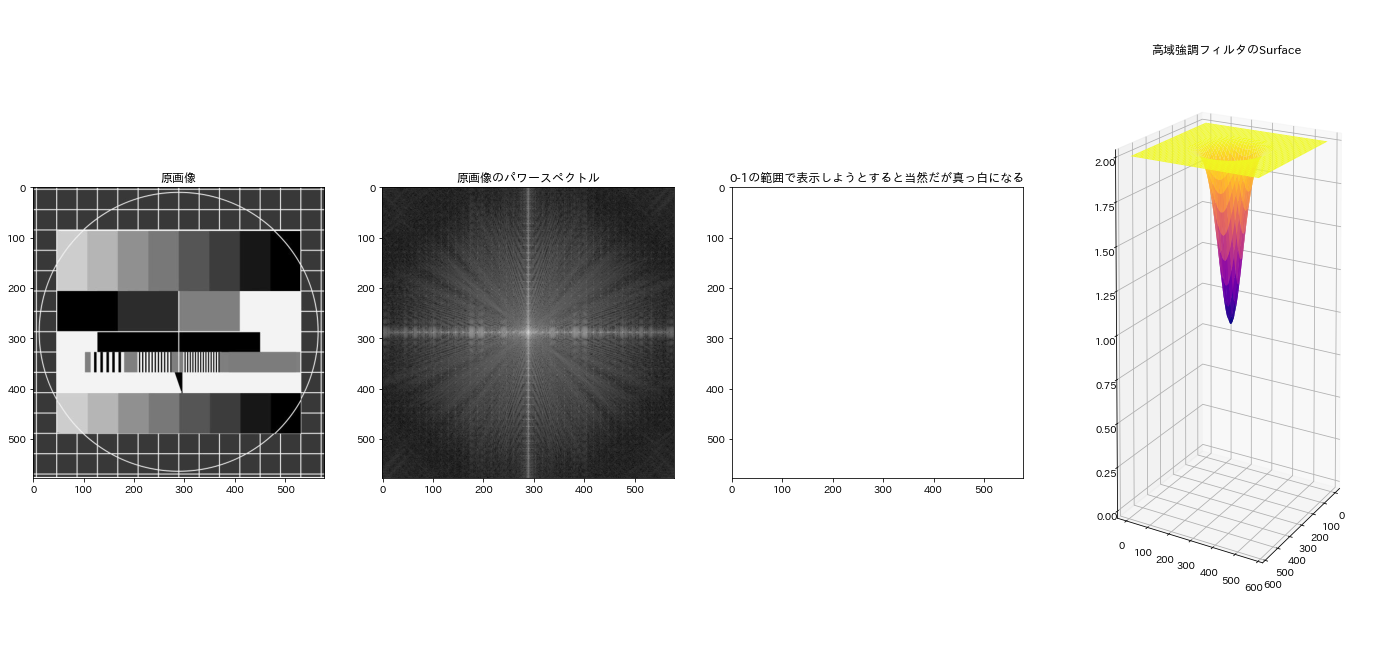

In [15]:
from mpl_toolkits.mplot3d import axes3d
gimg = cv2.imread('IRIB_Testcard_(FuBK_Version).jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = gimg[:, 95:95+578]
fgimg = np.fft.fft2(gimg)
fgimg = np.fft.fftshift(fgimg)
tmpimg = np.zeros(gimg.shape)
h, w = gimg.shape
cutoff = [10, 60, 120, 320]
kern = cv2.getGaussianKernel(cutoff[3],-1)
kern2 = np.dot(kern, kern.T)
kern2 = kern2/kern2.max()

mask = np.zeros(gimg.shape)
mask[h//2 - cutoff[3]//2:h//2+cutoff[3]//2,w//2 - cutoff[3]//2:w//2+cutoff[3]//2] = kern2
mask = 1-mask

mask = 1+mask
plt.subplot(1,4,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(1,4,2)
plt.imshow(10*tmpimg+np.log(np.abs(fgimg)+1), cmap='gray')
plt.title('原画像のパワースペクトル')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray', vmin = 0, vmax=1)
plt.title('0-1の範囲で表示しようとすると当然だが真っ白になる')
ax3d = plt.subplot(1,4,4, projection = '3d')
x = np.linspace(0, mask.shape[1], num=mask.shape[1])
y = np.linspace(0, mask.shape[0], num=mask.shape[0])
X, Y = np.meshgrid(x,y)
#ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=10, azim=30)
ax3d.plot_surface(X, Y, mask, cmap='plasma')
ax3d.set_zlim(0, 2.0);
plt.title('高域強調フィルタのSurface');

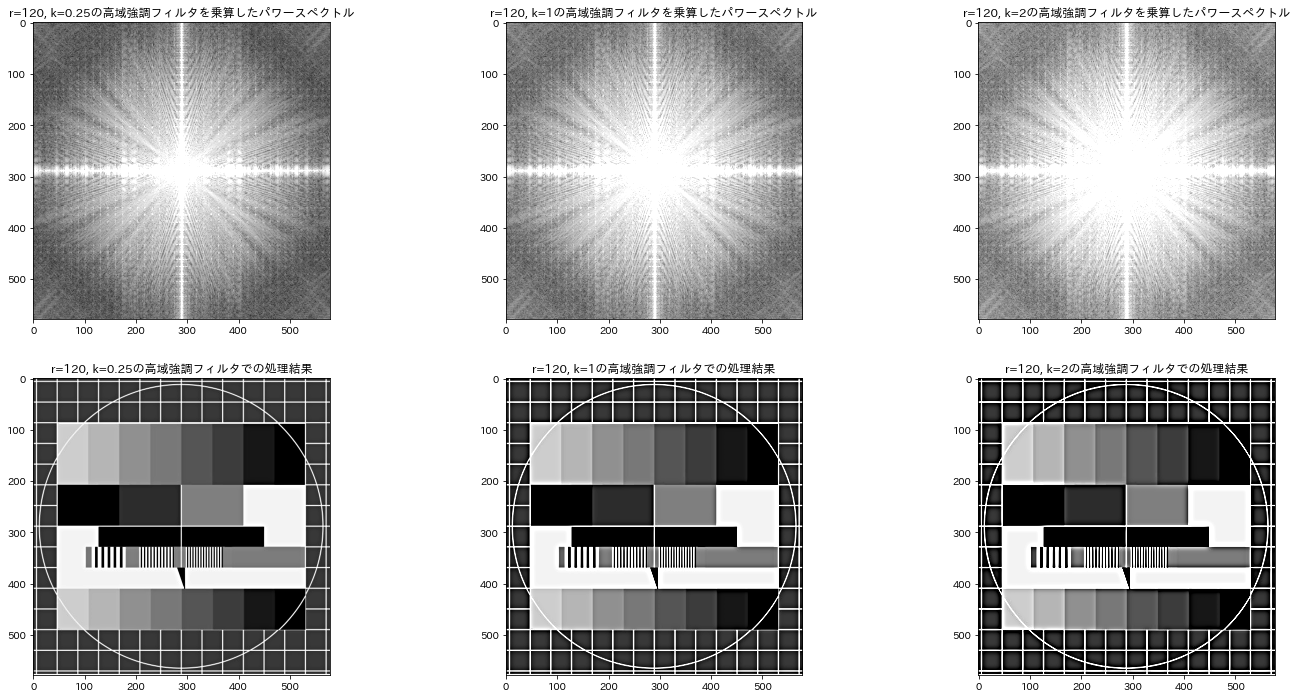

In [16]:
kval = [0.25, 1, 2]
for i, k in enumerate(kval):
  r = 120
  kern = cv2.getGaussianKernel(r,-1)
  kern2 = np.dot(kern, kern.T)
  kern2 = kern2/kern2.max()
  mask = np.zeros(gimg.shape)
  mask[h//2 - r//2:h//2+r//2,w//2 - r//2:w//2+r//2] = kern2
  mask = 1 - mask
  mask = 1 + k * mask
  fmaskedimg = fgimg * mask
  plt.subplot(2,3,i+1)
  plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray', vmin=0, vmax=5)
  plt.title(f'r={r}, k={k}の高域強調フィルタを乗算したパワースペクトル')
  fmaskedimg = np.fft.fftshift(fmaskedimg)
  maskedimg = np.fft.ifft2(fmaskedimg)
  plt.subplot(2,3, i+4)
  plt.imshow(np.real(maskedimg), cmap='gray', vmin=0, vmax=1)
  plt.title(f'r={r}, k={k}の高域強調フィルタでの処理結果')

# cos^2ウィンドウにしましまを重ねたものとのαブレンディング
cos2imgとsampleを混ぜてみる。

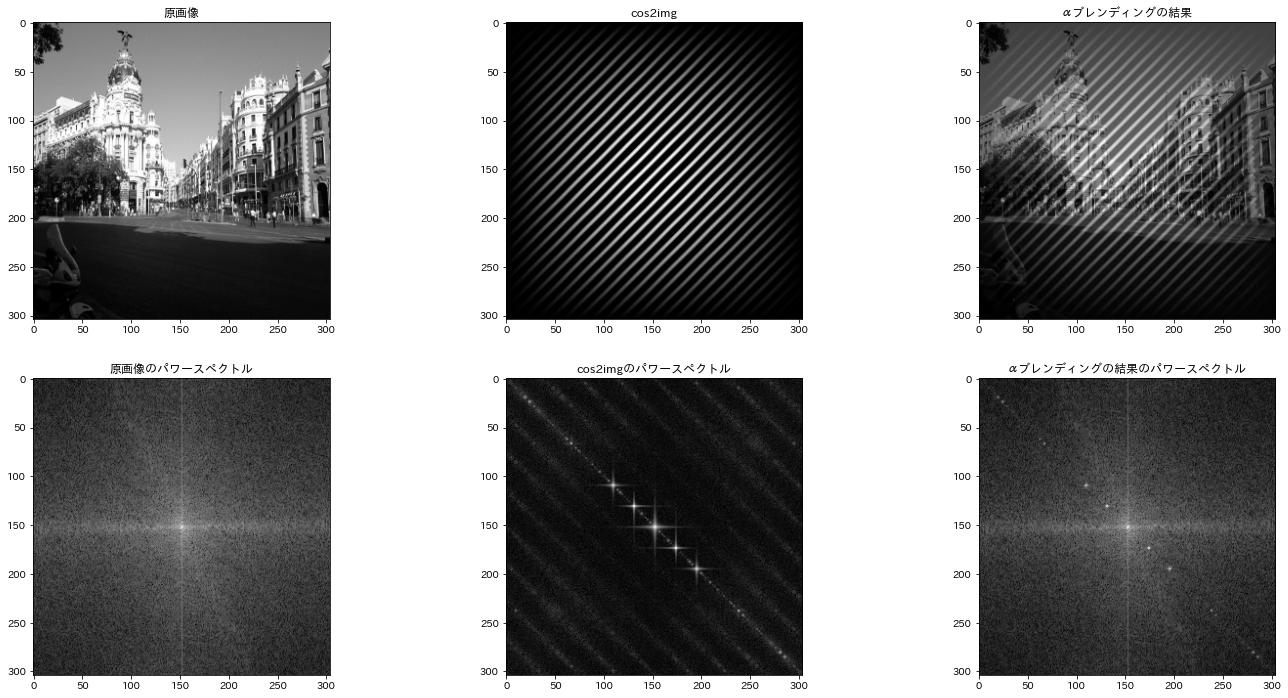

In [17]:
cos2img = cv2.imread('cos2img.jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)/255.
gimg = cv2.resize(gimg, cos2img.shape)
blendedimg = cos2img*0.5 + gimg*0.5
plt.subplot(2,3,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(2,3,2)
plt.imshow(cos2img, cmap='gray')
plt.title('cos2img')
plt.subplot(2,3,3)
plt.imshow(blendedimg, cmap='gray')
plt.title('αブレンディングの結果')
fimg = np.fft.fft2(gimg)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(fimg)+1), cmap='gray')
plt.title('原画像のパワースペクトル')
fcos2img = np.fft.fft2(cos2img)
fcos2img = np.fft.fftshift(fcos2img)
plt.subplot(2,3,5)
plt.imshow(np.log(np.abs(fcos2img)+1), cmap='gray')
plt.title('cos2imgのパワースペクトル')
fblendedimg = np.fft.fft2(blendedimg)
fblendedimg = np.fft.fftshift(fblendedimg)
plt.subplot(2,3,6)
plt.imshow(np.log(np.abs(fblendedimg)+1), cmap='gray')
plt.title('αブレンディングの結果のパワースペクトル');


## 選択的フィルタリングの例
パワースペクトル上で特異的な値となっている箇所をピンポイントで0にしてノイズを除去する。cos2imgは斜め方向に矩形波があるのでパワースペクトル上にも飛び飛びでピークが現れる。ただし、原点を0にしてしまうと直流成分が失われるので避ける。

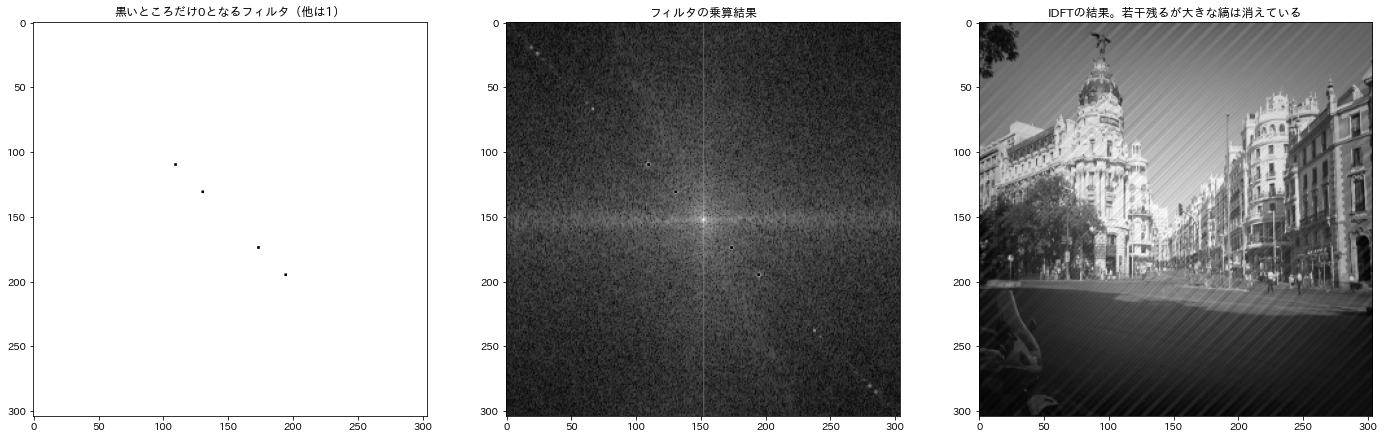

In [18]:
fblendedimg = np.fft.fft2(blendedimg)
fblendedimg = np.fft.fftshift(fblendedimg)
rows, cols = np.where(np.abs(fblendedimg)>500)
# パワースペクトルが大きい点を探しゼロに埋めたいが，直流付近は含めないようにする
cols = cols[np.where(((rows>140)& (159>rows)), False, True)]
rows = rows[np.where(((rows>140)& (159>rows)), False, True)]
mask = np.ones(blendedimg.shape, dtype=np.float)
mask[rows, cols] = 0
fmaskedblendedimg = fblendedimg*mask
plt.subplot(1,3,1)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1.0)
plt.title('黒いところだけ0となるフィルタ（他は1）')
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(fmaskedblendedimg)+1), cmap='gray')
plt.title('フィルタの乗算結果')
fmaskedblendedimg = np.fft.fftshift(fmaskedblendedimg)
maskedblendedimg = np.fft.ifft2(fmaskedblendedimg)
plt.subplot(1,3,3)
plt.imshow(np.real(maskedblendedimg), cmap='gray')
plt.title('IDFTの結果。若干残るが大きな縞は消えている');

# 土星探査機カッシーニからの土星の輪の映像からノイズを除去する
搭載しているのがラインセンサのため画像の1行ごとに強度が変化する。結果として強い横方向の縞がノイズとして乗った状態で観測される。
センサと垂直の方向にのみに発生する点を利用して、直流成分付近以外を除去するフィルタを作成する。

最大値は 512 番目


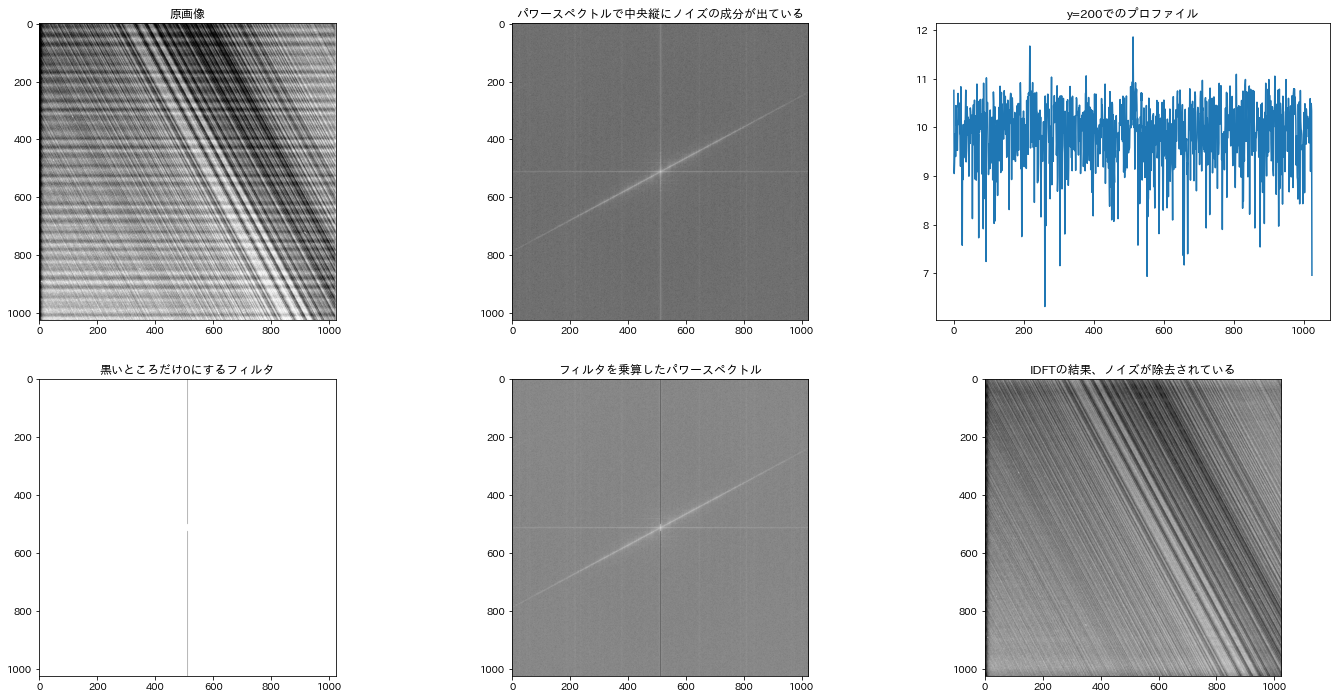

In [19]:
gimg = cv2.imread('Saturn_s_rings_-_1_July_2004.jpe', cv2.IMREAD_GRAYSCALE)
fimg = np.fft.fft2(gimg)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,3,1)
plt.imshow(gimg, cmap='gray')
plt.title('原画像')
plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(fimg)+1), cmap='gray')
plt.title('パワースペクトルで中央縦にノイズの成分が出ている')
plt.subplot(2,3,3)
plt.plot(np.log(np.abs(fimg[200,:])+1));
plt.title('y=200でのプロファイル')
print('最大値は', np.abs(fimg[200,:]).argmax() , '番目')
mask = np.ones((1024,1024))
mask[0:500, 512] = 0
mask[524:1024, 512] = 0
plt.subplot(2,3,4)
plt.imshow(mask, cmap='gray')
plt.title('黒いところだけ0にするフィルタ')
fmaskedimg = fimg*mask
plt.subplot(2,3,5)
plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
plt.title('フィルタを乗算したパワースペクトル')
fmaskedimg = np.fft.fftshift(fmaskedimg)
maskedimg = np.fft.ifft2(fmaskedimg)
plt.subplot(2,3,6)
plt.imshow(np.real(maskedimg), cmap='gray')
plt.title('IDFTの結果、ノイズが除去されている');

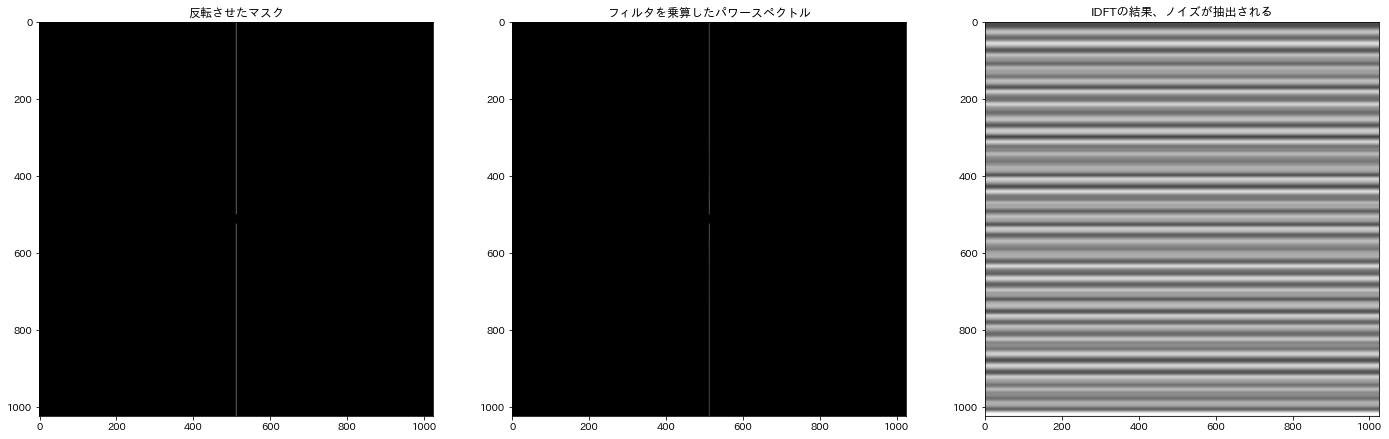

In [20]:
mask = 1 - mask
fmaskedimg = fimg*mask
plt.subplot(1,3,1)
plt.imshow(mask, cmap='gray')
plt.title('反転させたマスク')
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(fmaskedimg)+1), cmap='gray')
plt.title('フィルタを乗算したパワースペクトル')
fmaskedimg = np.fft.fftshift(fmaskedimg)
maskedimg = np.fft.ifft2(fmaskedimg)
plt.subplot(1,3,3)
plt.imshow(np.real(maskedimg), cmap='gray')
plt.title('IDFTの結果、ノイズが抽出される');